In [ ]:
import pyNUISANCE as pn
import numpy as np
import pyProSelecta as pps

In [2]:
# pn.log.set_level("EventInput", pn.log.level.trace)

In [3]:
neut_event_stream = pn.EventSource("neutvect.t2kflux_numu_C_nofsi.root")
if not neut_event_stream:
    print("Error: failed to open input file")

In [4]:
# Manual event loop, manual projection
for i, (event, cv_weight) in enumerate(neut_event_stream):
    intmode = pps.event.signal_process_id(event)

    if not pps.event.has_out_part(event, 13): continue

    # grab highest momentum real final state muon
    muon = pps.event.hm_out_part(event, 13)
    mumom_MeV = muon.momentum().p3mod()
    
    print(f"event {i}: interaction mode = {intmode}, cv_weight = {cv_weight}, muon momentum = {mumom_MeV:.4} MeV/c")
    if i >= 10: break

event 2: interaction mode = 400, cv_weight = 1.0, muon momentum = 245.5 MeV/c
event 3: interaction mode = 200, cv_weight = 1.0, muon momentum = 250.7 MeV/c
event 4: interaction mode = 200, cv_weight = 1.0, muon momentum = 469.2 MeV/c
event 7: interaction mode = 402, cv_weight = 1.0, muon momentum = 1.722e+03 MeV/c
event 8: interaction mode = 200, cv_weight = 1.0, muon momentum = 744.4 MeV/c
event 11: interaction mode = 500, cv_weight = 1.0, muon momentum = 87.76 MeV/c


In [5]:
# Manual event loop, library-defined projection
for i, (event, cv_weight) in enumerate(neut_event_stream):
    intmode = pps.event.signal_process_id(event)
    
    plep = pps.ext.plep_GeV(event)
    etransfer = pps.ext.q0lep_GeV(event)
    
    print(f"event {i}: interaction mode = {intmode}, cv_weight = {cv_weight}")
    print(f"  plep = {plep:.2} GeV/c, q_0 = {etransfer:.2} GeV")
    if i >= 10:
        break

event 0: interaction mode = 251, cv_weight = 1.0
  plep = 0.34 GeV/c, q_0 = 0.14 GeV
event 1: interaction mode = 550, cv_weight = 1.0
  plep = 1.5 GeV/c, q_0 = 1.7 GeV
event 2: interaction mode = 400, cv_weight = 1.0
  plep = 0.25 GeV/c, q_0 = 0.41 GeV
event 3: interaction mode = 200, cv_weight = 1.0
  plep = 0.25 GeV/c, q_0 = 0.076 GeV
event 4: interaction mode = 200, cv_weight = 1.0
  plep = 0.47 GeV/c, q_0 = 0.16 GeV
event 5: interaction mode = 251, cv_weight = 1.0
  plep = 0.5 GeV/c, q_0 = 0.2 GeV
event 6: interaction mode = 250, cv_weight = 1.0
  plep = 0.48 GeV/c, q_0 = 0.062 GeV
event 7: interaction mode = 402, cv_weight = 1.0
  plep = 1.7 GeV/c, q_0 = 0.57 GeV
event 8: interaction mode = 200, cv_weight = 1.0
  plep = 0.74 GeV/c, q_0 = 0.12 GeV
event 9: interaction mode = 251, cv_weight = 1.0
  plep = 0.42 GeV/c, q_0 = 0.1 GeV
event 10: interaction mode = 450, cv_weight = 1.0
  plep = 0.93 GeV/c, q_0 = 0.33 GeV


In [6]:
%%time
# Simple 1D Histogram
start = 0
stop = 2
nbins = 100
myhist = pn.HistFrame(pn.Binning.lin_space(start,stop,nbins, "$p_\mu$ [GeV/c]"))

# Manual event loop, manual filling
for event, cv_weight in neut_event_stream:
    plep = pps.ext.plep_GeV(event)
    myhist.fill(plep, cv_weight)

CPU times: user 26.1 s, sys: 194 ms, total: 26.3 s
Wall time: 26.3 s


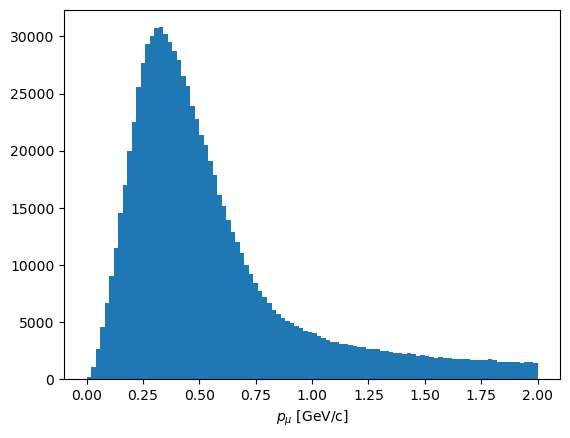

In [7]:
import matplotlib.pyplot as plt

myhist.mpl().hist()
plt.show()

In [8]:
%%time
# Simple 2D Histogram
myhist2 = pn.HistFrame(pn.Binning.lin_spaceND([(0,2,100),(0,1,100)],["$p_\mu$ [GeV/c]","$q_0$ [GeV]"]))

# Manual event loop, manual filling
for event, cv_weight in neut_event_stream:
    plep = pps.ext.plep_GeV(event)
    etransfer = pps.ext.q0lep_GeV(event)
    myhist2.fill([plep, etransfer], cv_weight)

CPU times: user 28.3 s, sys: 94 ms, total: 28.4 s
Wall time: 28.4 s


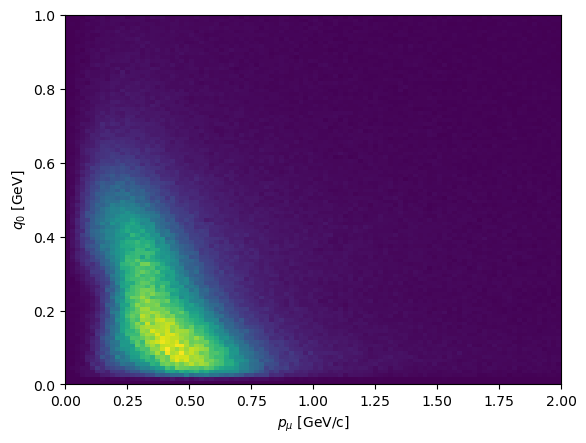

In [9]:
myhist2.mpl().hist2d()
plt.show()

In [10]:
%%time
# Simple 1D Histogram
myhist = pn.HistFrame(pn.Binning.lin_space(0,2,100,"$p_\mu$ [GeV/c]"))
col_cc0pi = myhist.add_column("CC0Pi")
col_cc1pi = myhist.add_column("CC1Pi")
col_nc = myhist.add_column("NC")

# Manual event loop, manual filling, manual sub-sampling
for event, cv_weight in neut_event_stream:
    plep = pps.ext.plep_GeV(event)

    # fills column 0 by default
    myhist.fill(plep, cv_weight)
    
    if pps.ext.isCC0Pi(event):
        myhist.fill_column(plep, cv_weight, col_cc0pi)
    
    if pps.ext.isCC1Pi(event):
        myhist.fill_column(plep, cv_weight, col_cc1pi)
    
    if not pps.ext.isCC(event):
        myhist.fill_column(plep, cv_weight, col_nc)

CPU times: user 28.5 s, sys: 108 ms, total: 28.7 s
Wall time: 28.6 s


In [11]:
print(myhist.sumweights)

[[2.0700e+02 1.6000e+01 6.4000e+01 2.9000e+01]
 [1.0690e+03 1.0400e+02 4.7500e+02 1.6900e+02]
 [2.6220e+03 2.8100e+02 1.2340e+03 5.1700e+02]
 [4.5980e+03 5.8800e+02 2.1060e+03 1.0110e+03]
 [6.7160e+03 9.9300e+02 3.0390e+03 1.5050e+03]
 [9.0710e+03 1.6260e+03 4.0270e+03 2.0460e+03]
 [1.1525e+04 2.4560e+03 4.8130e+03 2.6070e+03]
 [1.4575e+04 3.7910e+03 5.5790e+03 3.3300e+03]
 [1.6963e+04 5.0150e+03 5.8540e+03 3.9550e+03]
 [1.9956e+04 6.9600e+03 6.2000e+03 4.5830e+03]
 [2.2475e+04 8.7280e+03 6.1830e+03 5.3050e+03]
 [2.5536e+04 1.0776e+04 6.3130e+03 6.0260e+03]
 [2.7718e+04 1.2424e+04 6.1080e+03 6.6830e+03]
 [2.9315e+04 1.3891e+04 5.8970e+03 6.9900e+03]
 [3.0055e+04 1.4811e+04 5.5070e+03 7.2360e+03]
 [3.0724e+04 1.5612e+04 5.1000e+03 7.5470e+03]
 [3.0789e+04 1.6018e+04 4.8920e+03 7.5440e+03]
 [3.0244e+04 1.5831e+04 4.6470e+03 7.4300e+03]
 [2.9486e+04 1.5766e+04 4.1570e+03 7.2850e+03]
 [2.8692e+04 1.5509e+04 3.9420e+03 7.0930e+03]
 [2.7943e+04 1.5358e+04 3.6500e+03 6.9090e+03]
 [2.6556e+04 

In [12]:
print(myhist)

 ------------------------------------------------------------------------------
 | bin |        mc |   err |     CC0Pi |   err | CC1Pi |   err |   NC |   err |
 ------------------------------------------------------------------------------
 |   0 |       207 | 14.39 |        16 |     4 |    64 |     8 |   29 | 5.385 |
 |   1 |      1069 |  32.7 |       104 |  10.2 |   475 | 21.79 |  169 |    13 |
 |   2 |      2622 | 51.21 |       281 | 16.76 |  1234 | 35.13 |  517 | 22.74 |
 |   3 |      4598 | 67.81 |       588 | 24.25 |  2106 | 45.89 | 1011 |  31.8 |
 |   4 |      6716 | 81.95 |       993 | 31.51 |  3039 | 55.13 | 1505 | 38.79 |
 |   5 |      9071 | 95.24 |      1626 | 40.32 |  4027 | 63.46 | 2046 | 45.23 |
 |   6 | 1.152e+04 | 107.4 |      2456 | 49.56 |  4813 | 69.38 | 2607 | 51.06 |
 |   7 | 1.458e+04 | 120.7 |      3791 | 61.57 |  5579 | 74.69 | 3330 | 57.71 |
 |   8 | 1.696e+04 | 130.2 |      5015 | 70.82 |  5854 | 76.51 | 3955 | 62.89 |
 |   9 | 1.996e+04 | 141.3 |      6960 |

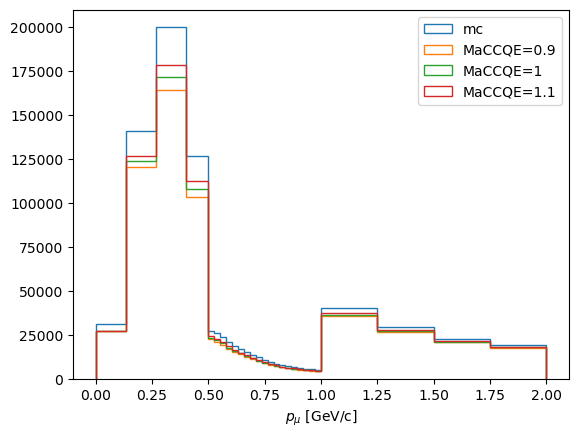

In [35]:
myhist.mpl().hist_all(histtype="step")
plt.legend()
plt.show()

In [14]:
%%time
import numpy as np

bin_edges_plep = np.concatenate((np.linspace(0,0.4,4), np.linspace(0.5,1,20), np.linspace(1.25,2,4)))

myhist = pn.HistFrame(pn.Binning.contiguous(list(bin_edges_plep), "$p_\mu$ [GeV/c]"))

# Manual event loop, manual filling, manual sub-sampling
for event, cv_weight in neut_event_stream:
    plep = pps.ext.plep_GeV(event)

    myhist.fill(plep, cv_weight)

CPU times: user 26.5 s, sys: 122 ms, total: 26.6 s
Wall time: 26.6 s


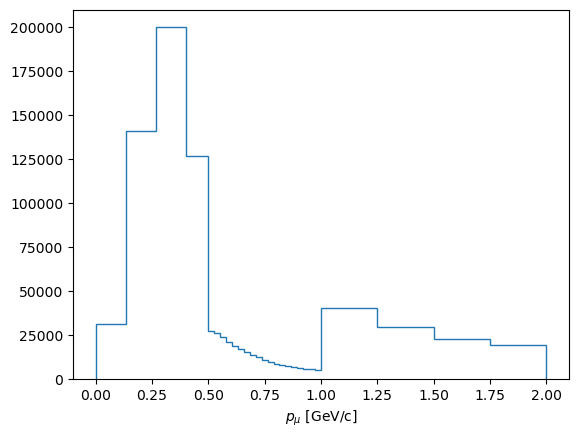

In [15]:
myhist.mpl().hist(histtype="step")
plt.show()

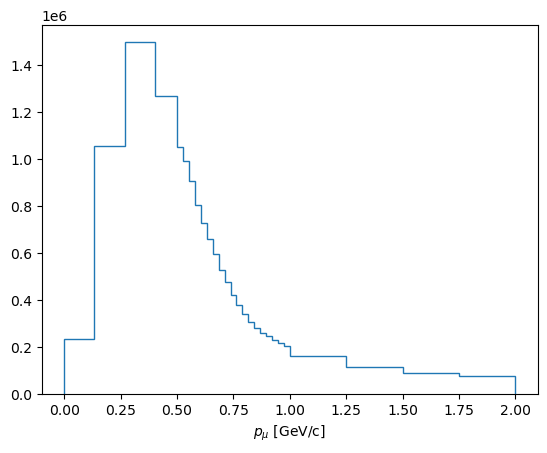

In [16]:
myfinalizedhist = myhist.finalise()
myfinalizedhist.mpl().hist(histtype="step")
plt.show()

# Event Frames

In [17]:
df = pn.EventFrameGen(neut_event_stream).first(20)
print(df)

 -----------------------------------------
 | event.number | weight.cv | process.id |
 -----------------------------------------
 |            0 |         1 |        251 |
 |            1 |         1 |        550 |
 |            2 |         1 |        400 |
 |            3 |         1 |        200 |
 |            4 |         1 |        200 |
 |            5 |         1 |        251 |
 |            6 |         1 |        250 |
 |            7 |         1 |        402 |
 |            8 |         1 |        200 |
 |            9 |         1 |        251 |
 |           10 |         1 |        450 |
 |           11 |         1 |        500 |
 |           12 |         1 |        550 |
 |           13 |         1 |        200 |
 |           14 |         1 |        200 |
 |           15 |         1 |        250 |
 |           16 |         1 |        452 |
 |           17 |         1 |        200 |
 |           18 |         1 |        200 |
 |           19 |         1 |        250 |
 ----------

In [18]:
df = pn.EventFrameGen(neut_event_stream) \
    .filter(lambda ev: pps.event.signal_process_id(ev) == 200) \
    .first(20)
print(df)

 -----------------------------------------
 | event.number | weight.cv | process.id |
 -----------------------------------------
 |            3 |         1 |        200 |
 |            4 |         1 |        200 |
 |            8 |         1 |        200 |
 |           13 |         1 |        200 |
 |           14 |         1 |        200 |
 |           17 |         1 |        200 |
 |           18 |         1 |        200 |
 |           21 |         1 |        200 |
 |           26 |         1 |        200 |
 |           31 |         1 |        200 |
 |           33 |         1 |        200 |
 |           34 |         1 |        200 |
 |           36 |         1 |        200 |
 |           37 |         1 |        200 |
 |           38 |         1 |        200 |
 |           43 |         1 |        200 |
 |           45 |         1 |        200 |
 |           47 |         1 |        200 |
 |           50 |         1 |        200 |
 |           53 |         1 |        200 |
 ----------

In [19]:
df = pn.EventFrameGen(neut_event_stream) \
    .filter(pps.ext.isCC0Pi) \
    .add_column("plep", pps.ext.plep_GeV) \
    .first(20)
print(df)

 --------------------------------------------------
 | event.number | weight.cv | process.id |   plep |
 --------------------------------------------------
 |            3 |         1 |        200 | 0.2507 |
 |            4 |         1 |        200 | 0.4692 |
 |            8 |         1 |        200 | 0.7444 |
 |           13 |         1 |        200 | 0.4635 |
 |           14 |         1 |        200 |   0.52 |
 |           17 |         1 |        200 | 0.2926 |
 |           18 |         1 |        200 | 0.5598 |
 |           21 |         1 |        200 | 0.6372 |
 |           26 |         1 |        200 | 0.2029 |
 |           31 |         1 |        200 | 0.3437 |
 |           33 |         1 |        200 | 0.3552 |
 |           34 |         1 |        200 |  0.515 |
 |           36 |         1 |        200 | 0.1452 |
 |           37 |         1 |        200 | 0.8151 |
 |           38 |         1 |        200 | 0.4112 |
 |           43 |         1 |        200 | 0.3534 |
 |          

In [20]:
pps.load_text("""
double GetPt_MeV(HepMC3::GenEvent const &evt){
    return ps::part::sum(ps::momentum, ps::event::all_out_part(evt, ps::pids(13, 2212), ps::flatten)).pt();
}
""")
projpt = pps.project.get("GetPt_MeV")

for i, (event, cv_weight) in enumerate(neut_event_stream):
    print(projpt(event))
    if i >= 10:
        break

0.0
0.0
101.08175526701895
164.30585008487813
240.98548014705926
0.0
225.17673269008847
544.1583621299505
135.14434054688223
0.0
0.0


In [21]:
df = pn.EventFrameGen(neut_event_stream) \
    .filter(pps.ext.isCC0Pi) \
    .add_column("pt", projpt) \
    .first(20)
print(df)

 -----------------------------------------------------
 | event.number | weight.cv | process.id |        pt |
 -----------------------------------------------------
 |            3 |         1 |        200 |     164.3 |
 |            4 |         1 |        200 |       241 |
 |            8 |         1 |        200 |     135.1 |
 |           13 |         1 |        200 |     124.6 |
 |           14 |         1 |        200 |     188.3 |
 |           17 |         1 |        200 |     23.65 |
 |           18 |         1 |        200 |     82.82 |
 |           21 |         1 |        200 |     144.9 |
 |           26 |         1 |        200 |     263.9 |
 |           31 |         1 |        200 |     160.3 |
 |           33 |         1 |        200 |     124.5 |
 |           34 |         1 |        200 |     213.3 |
 |           36 |         1 |        200 |     152.1 |
 |           37 |         1 |        200 |     135.9 |
 |           38 |         1 |        200 |     206.1 |
 |        

In [43]:
dfa = pn.EventFrameGen(neut_event_stream) \
    .filter(pps.ext.isCC0Pi) \
    .add_column("plep", pps.ext.plep_GeV) \
    .add_column("pt", projpt) \
    .firstArrow(20).to_pandas()
dfa
dfa = pn.EventFrameGen(neut_event_stream) \
    .filter(pps.ext.isCC0Pi) \
    .add_column("plep", pps.ext.plep_GeV) \
    .add_column("pt", projpt) \
    .firstArrow(20)
print(dfa)

pyarrow.RecordBatch
event.number: int64
weight.cv: double
process.id: int64
fatx.estimate: double
plep: double
pt: double


In [23]:
dfa.to_parquet("myeventtable.pq")

In [24]:
%%time
df = pn.EventFrameGen(neut_event_stream) \
    .add_column("plep", pps.ext.plep_GeV) \
    .add_column("pt", projpt) \
    .all()
print(df)
print(df.num_rows)

 -----------------------------------------------------------
 | event.number | weight.cv | process.id |    plep |    pt |
 -----------------------------------------------------------
 |            0 |         1 |        251 |  0.3375 |     0 |
 |            1 |         1 |        550 |   1.529 |     0 |
 |            2 |         1 |        400 |  0.2455 | 101.1 |
 |            3 |         1 |        200 |  0.2507 | 164.3 |
 |            4 |         1 |        200 |  0.4692 |   241 |
 |            5 |         1 |        251 |  0.4967 |     0 |
 |            6 |         1 |        250 |   0.479 | 225.2 |
 |            7 |         1 |        402 |   1.722 | 544.2 |
 |            8 |         1 |        200 |  0.7444 | 135.1 |
 |            9 |         1 |        251 |  0.4207 |     0 |
 |           10 |         1 |        450 |  0.9327 |     0 |
 |           11 |         1 |        500 | 0.08776 | 252.1 |
 |           12 |         1 |        550 |   1.356 | 9.922 |
 |           13 |       

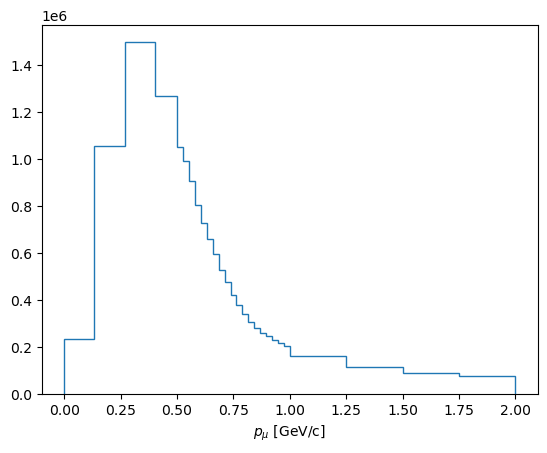

CPU times: user 102 ms, sys: 5.02 ms, total: 107 ms
Wall time: 103 ms


In [25]:
%%time
myhist = pn.HistFrame(pn.Binning.contiguous(list(bin_edges_plep), "$p_\mu$ [GeV/c]"))
myhist.fill_from_EventFrame(df, ["plep"])
myhist.finalise().mpl().hist(histtype="step")
plt.show()

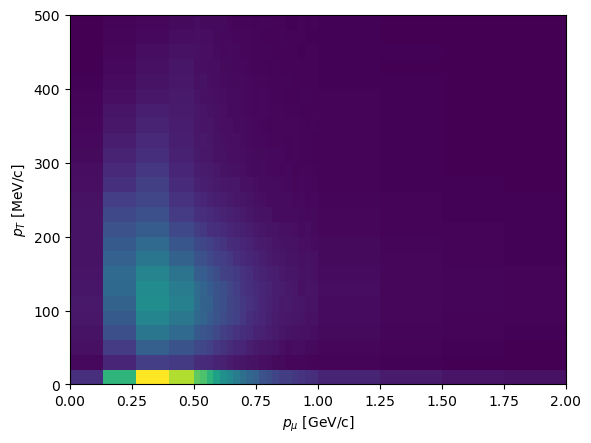

CPU times: user 134 ms, sys: 6.02 ms, total: 140 ms
Wall time: 138 ms


In [26]:
%%time
plepbinning = pn.Binning.contiguous(list(bin_edges_plep),"$p_\mu$ [GeV/c]")
twodbinning = pn.Binning.product([plepbinning, pn.Binning.lin_space(0,500,25, "$p_T$ [MeV/c]")])
myhist = pn.HistFrame(twodbinning)

myhist.fill_from_EventFrame(df, ["plep","pt"])
myhist.finalise().mpl().hist2d()
plt.show()

# Responses

In [27]:
wf = pn.WeightCalcFactory()
t2krw = wf.make(neut_event_stream, {"plugin_name":"T2KReWeight", "neut_cardname": "neut.t2kflux_numu_C_nofsi.card"})

 CRSPATH_ENV: /opt/neut/5.8.0/share/neut/crsdat
 Reading neut.t2kflux_numu_C_nofsi.card as card
 ======= CONFIGURATION FOR INTERACTIONS =======
 Reading neut.t2kflux_numu_C_nofsi.card as a card file
 Using Spectral Function for elastic events
 NECARD : INPUTTED PARAMETER 
 NECARD : CRSPATH= /opt/neut/5.8.0/share/neut/crsdat/
 NECARD : FERM   =            0
 NECARD : PAUL   =            1
 NECARD : PAUL2p2h =            0
 NECARD : NEFF   =            1
 NECARD : NUCDEXITE =            0
 NECARD : MODL   =            1
 NECARD : MODH   =            1
 NECARD : KINH   =            1
 NECARD : MODE   =            0
 NECARD : COHEPI =            2
 NECARD : DIFPI  =            0
 ********* CCQE SETTINGS ***************
 NECARD : MDLQE   =          402
 NECARD : MDLQEAF =            1
 NECARD : MDL2P2H =            2
 NECARD : NV2P2HQVAL =            1
 NECARD : MAQE    =    1.21000004    
 NECARD : AXFFALPHA =  0.230000004    
 NECARD : AXFFBETA=   1.22000003    
 NECARD : AXFFGAMMA=  0.43

In [28]:
def wghts(ev):
    wghts = []
    t2krw.set_parameters({"MaCCQE": 0.9})
    wghts.append(t2krw.calc_weight(ev))
    t2krw.set_parameters({"MaCCQE": 1})
    wghts.append(t2krw.calc_weight(ev))
    t2krw.set_parameters({"MaCCQE": 1.1})
    wghts.append(t2krw.calc_weight(ev))
    return wghts

In [ ]:
dfa = pn.EventFrameGen(neut_event_stream) \
    .add_column("plep", pps.ext.plep_GeV) \
    .add_columns(["MaCCQE=0.9","MaCCQE=1","MaCCQE=1.1"], wghts) \
    .firstArrow(int(1E6))

In [30]:
dfa.to_pandas().to_parquet("evsmaqesplines.pq")

In [31]:
import pandas as pd
import pyarrow as pa
dfa = pa.Table.from_pandas(pd.read_parquet("evsmaqesplines.pq"))
dfa.to_pandas()

,event.number,weight.cv,process.id,fatx.estimate,plep,MaCCQE=0.9,MaCCQE=1,MaCCQE=1.1
0,0,1.0,251,0.127882,0.337458,1.000000,1.000000,1.000000
1,1,1.0,550,0.127882,1.529301,1.000000,1.000000,1.000000
2,2,1.0,400,0.127882,0.245524,0.000000,0.000000,0.000000
3,3,1.0,200,0.127882,0.250665,0.905294,0.943487,0.973691
4,4,1.0,200,0.127882,0.469167,0.717949,0.815163,0.906984
...,...,...,...,...,...,...,...,...
999995,999995,1.0,250,0.127882,0.621384,1.000000,1.000000,1.000000
999996,999996,1.0,450,0.127882,0.439775,1.000000,1.000000,1.000000
999997,999997,1.0,600,0.127882,1.109527,1.000000,1.000000,1.000000
999998,999998,1.0,300,0.127882,0.542495,1.000000,1.000000,1.000000


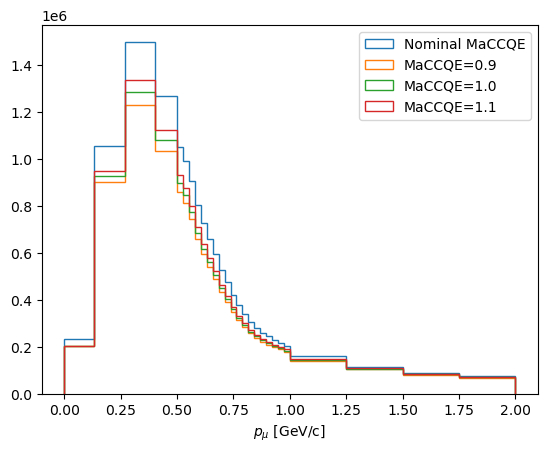

CPU times: user 157 ms, sys: 8.02 ms, total: 165 ms
Wall time: 160 ms


In [32]:
%%time
binning = pn.Binning.contiguous(list(bin_edges_plep), "$p_\mu$ [GeV/c]")
myhist = pn.HistFrame(binning)
myhist.fill_weighted_columns_from_Arrow(dfa, ["plep"], ["MaCCQE=0.9","MaCCQE=1","MaCCQE=1.1"])
myhist.finalise().mpl().hist_all(histtype="step", labels=["Nominal MaCCQE","MaCCQE=0.9","MaCCQE=1.0","MaCCQE=1.1"])
plt.legend()
plt.show()

In [33]:
df = pn.EventFrameGen(neut_event_stream) \
    .add_column("plep", pps.ext.plep_GeV) \
    .add_columns(["MaCCQE=0.9","MaCCQE=1","MaCCQE=1.1"], wghts) \
    .add_int_column("nombin", lambda ev: binning.find_bin(pps.ext.plep_GeV(ev))) \
    .first(20)
print(df)

 -------------------------------------------------------------------------------------------------
 | event.number | weight.cv | process.id |    plep | MaCCQE=0.9 | MaCCQE=1 | MaCCQE=1.1 | nombin |
 -------------------------------------------------------------------------------------------------
 |            0 |         1 |        251 |  0.3375 |          1 |        1 |          1 |      2 |
 |            1 |         1 |        550 |   1.529 |          1 |        1 |          1 |     25 |
 |            2 |         1 |        400 |  0.2455 |          0 |        0 |          0 |      1 |
 |            3 |         1 |        200 |  0.2507 |     0.9053 |   0.9435 |     0.9737 |      1 |
 |            4 |         1 |        200 |  0.4692 |     0.7179 |   0.8152 |      0.907 |      3 |
 |            5 |         1 |        251 |  0.4967 |          1 |        1 |          1 |      3 |
 |            6 |         1 |        250 |   0.479 |          1 |        1 |          1 |      3 |
 |        

In [37]:
sp = pn.response.NaturalCubicFrameSpline()
sp.build([0.9,1.0,1.1], df.table[0:10,4:7])
print(sp.coeffs)

[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.05293531e-01  9.43487144e-01  4.01911314e-01  3.41985754e-01
  -2.15668487e-18 -5.99255598e-01 -1.99751866e+00  1.99751866e+00]
 [ 7.17949492e-01  8.15162572e-01  9.85608972e-01  9.45174445e-01
   1.79719778e-18 -4.04345272e-01 -1.34781757e+00  1.34781757e+00]
 [ 1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   

In [38]:
print(sp.eval(1.05))

[1.         1.         0.         0.95933798 0.86157891 1.
 1.         1.         0.93611678 1.        ]
